<a href="https://colab.research.google.com/github/anavegaa/Tomato_leaf_disease_detection_deep_learning/blob/main/06%20-%20arquitectura%20vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🌱 Clasificación de Enfermedades en Hojas de Tomate con VGG16**

¿Por qué VGG16?
La arquitectura VGGNet, propuesta por Simonyan y Zisserman en 2014, es una de las redes convolucionales más influyentes en la clasificación de imágenes.
Su versión más conocida, VGG16, consiste en 16 capas de profundidad, organizadas de forma extremadamente simple y modular:

✅ **Arquitectura profunda pero homogénea**

Utiliza exclusivamente convoluciones de tamaño 3x3 (pequeños filtros que capturan bordes, texturas y patrones locales).

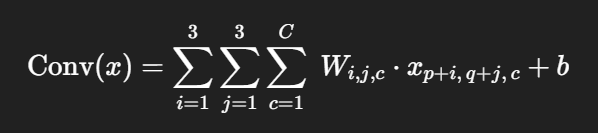

Cada bloque de convolución es seguido por max pooling, lo que reduce progresivamente la dimensión espacial.

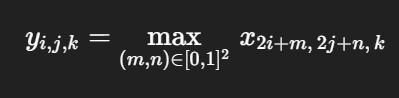

En la versión original, había 3 capas densas grandes (con 4096 neuronas cada una), pero en este proyecto usamos un Global Average Pooling, que computa el promedio por canal:

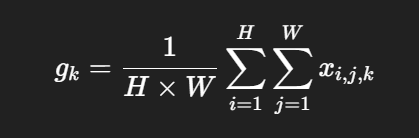

Esto produce un vector de tamaño igual al número de canales (en este caso, 512)

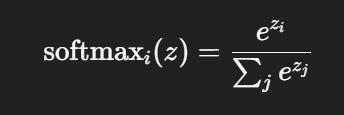

Al final, un bloque de capas densas genera las predicciones.



✅ **Gran capacidad de extracción de características visuales**

Gracias a la profundidad y la granularidad de sus filtros, VGG16 puede aprender representaciones de patrones muy detallados y sutiles, algo clave en problemas como:

* Clasificación de enfermedades en plantas.
* Diferenciación de clases visualmente similares.

✅ **Modelo preentrenado en ImageNet**

Los pesos de VGG16 han sido ajustados con millones de imágenes, lo que permite aprovechar conocimiento general sobre formas y texturas.

✅ **Estabilidad y consistencia**

Aunque es más grande y consume más recursos que arquitecturas más recientes, tiende a tener un rendimiento estable en datasets de tamaño mediano y con clases complejas.

VGG16 aporta varias ventajas:

* Gran capacidad de diferenciar clases con diferencias visuales sutiles.
* Facilidad de implementación y fine-tuning con TensorFlow/Keras.
* Consistencia al trabajar con imágenes de tamaño mayor (256x256).
* Amplia documentación y ejemplos de uso.

En comparación con MobileNet, Inception o ResNet, VGG16 sacrifica eficiencia computacional por un modelo simple, estable y probado, ideal si tu prioridad es la precisión y tu dataset es de tamaño intermedio

# 1. Librerías necesarias

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import zipfile
import os
import pandas as pd
import kagglehub

# 2. Descarga, definición de rutas y parámetros

Ve al dataset: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf/data

Haz clic en "Download" Download dataset as zip y subelo al notebook con:


In [ ]:
from google.colab import files
uploaded = files.upload()  # Selecciona el ZIP descargado

Saving archive.zip to archive.zip


In [ ]:
#Descomprimimos
filename = 'archive.zip'

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('tomatoleaf')

En este bloque se definen:

* Las rutas de los datos: dónde está la carpeta con las imágenes de entrenamiento y validación.

* Parámetros de entrada: tamaño de las imágenes que se alimentarán al modelo y el tamaño de lote (batch size).

In [ ]:
# Rutas base de las carpetas con imágenes
DATASET_PATH = Path("/content/tomatoleaf/tomato")
TRAIN_DATASET = DATASET_PATH / "train"
VAL_DATASET = DATASET_PATH / "val"

# Parámetros de entrada
IMG_HEIGHT = 224   # Alto de la imagen que se pasará al modelo
IMG_WIDTH = 224    # Ancho de la imagen que se pasará al modelo
BATCH_SIZE = 16    # Número de imágenes procesadas en cada batch

**¿Por qué las dimensiones 224x224 si las originales son de 256x256?**

Muchas arquitecturas de redes preentrenadas (por ejemplo, VGG16, ResNet, Inception) están optimizadas y preentrenadas sobre ImageNet, que usa imágenes de 224x224 píxeles.

Reducir de 256x256 a 224x224 no afecta significativamente la calidad visual y permite compatibilidad total con estos modelos preentrenados, además de reducir la carga computacional (memoria y tiempo de entrenamiento).

# 3. Carga de los datasets

In [ ]:
def cargar_dataset(ruta, shuffle):
    """
    Crea un tf.data.Dataset desde un directorio con imágenes.

    Parámetros:
    - ruta: ruta al directorio base que contiene subcarpetas de cada clase.
    - shuffle: booleano que indica si se mezclan las imágenes.

    Devuelve:
    - Un objeto tf.data.Dataset con imágenes y etiquetas.
    """
    return tf.keras.utils.image_dataset_from_directory(
        ruta,
        label_mode='int',                 # Etiquetas como enteros
        image_size=(IMG_HEIGHT, IMG_WIDTH),  # Redimensionar imágenes
        batch_size=BATCH_SIZE,           # Tamaño de lote
        shuffle=shuffle                  # Mezclar si es necesario
    )

# Cargar datasets de entrenamiento y validación
train_dataset = cargar_dataset(TRAIN_DATASET, shuffle=True)
val_dataset = cargar_dataset(VAL_DATASET, shuffle=False)

# Obtener lista de clases detectadas
class_names = train_dataset.class_names
num_classes = len(class_names)

print("Clases:", class_names)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.
Clases: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


Aquí se define una función cargar_dataset() que:

* Crea un dataset de TensorFlow (tf.data.Dataset) a partir de las carpetas con imágenes.
* Asigna etiquetas automáticamente según las carpetas.
* Redimensiona las imágenes al tamaño deseado.
* Crea lotes de tamaño BATCH_SIZE.

Se cargan dos datasets:
* train_dataset: para entrenamiento (con mezcla aleatoria).
* val_dataset: para validación (sin mezcla, para reproducibilidad).

Finalmente, se extraen los nombres de las clases detectadas.

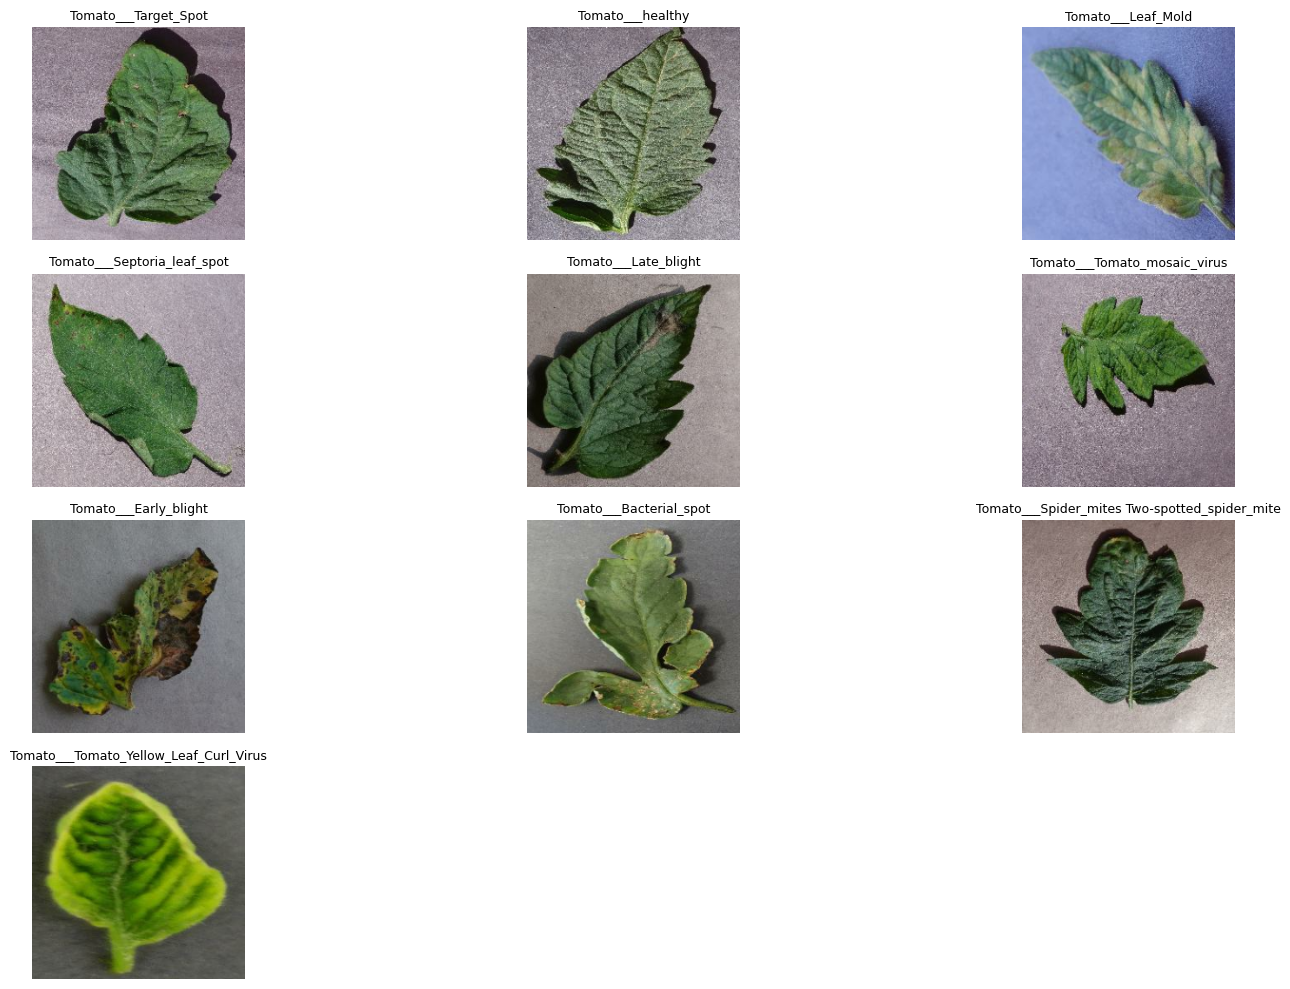

In [ ]:
# Visualización de ejemplos de cada clase
imagenes_por_clase = {}
for batch in train_dataset:
    images, labels = batch
    for img, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if class_name not in imagenes_por_clase:
            imagenes_por_clase[class_name] = img
        if len(imagenes_por_clase) == len(class_names):
            break
    if len(imagenes_por_clase) == len(class_names):
        break

plt.figure(figsize=(15, 10))
for idx, (class_name, image) in enumerate(imagenes_por_clase.items()):
    ax = plt.subplot(4, 3, idx + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_name, fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

# 4. Optimización del flujo de datos

Si no hacemos esto, cada época vuelve a:

* Leer desde disco.
* Decodificar cada imagen.
* Aplicar la transformación.

Lo que hace que el entrenamiento sea más lento y menos eficiente.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Cachea los datos procesados y prefetch para cargar lotes en paralelo
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

TensorFlow procesa los datos en pipelines que leen y transforman las imágenes antes de pasarlas al modelo.
Por defecto, esta carga puede ser lenta, ya que:

* Se leen imágenes del disco.
* Se decodifican y redimensionan.
* Se envían a la GPU en cada lote.

Este bloque optimiza este flujo:
* .cache()

1. Guarda en memoria (RAM) o disco los datos ya procesados en la primera época.
2. Así, en las siguientes épocas, se usan directamente sin volver a cargarlos ni decodificarlos.

* .prefetch()

1. Permite preparar el siguiente batch mientras el modelo está entrenando en el batch actual.
2. Esto acelera considerablemente el entrenamiento y mejora el uso de la GPU.

# 5. Construcción del modelo con VGG16

In [ ]:
def build_vgg16_model(input_shape, num_classes):
    """
    Construye un modelo VGG16 con capas superiores personalizadas y data augmentation.

    Parámetros:
    - input_shape: tupla (alto, ancho, canales) de la imagen.
    - num_classes: número de clases a clasificar.

    Devuelve:
    - model: modelo completo listo para entrenar.
    - base_model: el modelo VGG16 base (para descongelar si se desea).
    """

    # Aumento de datos aleatorio (augmentación)
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
    ], name="data_augmentation")

    # Modelo VGG16 preentrenado sin la cabeza final
    base_model = tf.keras.applications.VGG16(
        input_shape=input_shape,
        include_top=False,   # Quitamos la cabeza original de ImageNet
        weights='imagenet'   # Pesos preentrenados
    )
    base_model.trainable = False  # Congelamos todas las capas al principio

    # Entrada del modelo
    inputs = tf.keras.Input(shape=input_shape, name="input_image")

    # Pipeline de preprocesamiento
    x = data_augmentation(inputs)                                  # Augmentación
    x = tf.keras.applications.vgg16.preprocess_input(x)            # Preprocesamiento específico de VGG16
    x = base_model(x, training=False)                              # Extracción de características congeladas
    x = tf.keras.layers.GlobalAveragePooling2D()(x)                # Pooling global
    x = tf.keras.layers.Dropout(0.3)(x)                            # Regularización
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)  # Predicciones

    # Modelo completo
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="VGG16_Classifier")
    return model, base_model

En este bloque se crea el modelo basado en VGG16, una arquitectura famosa por su simplicidad y gran capacidad de extracción de características.

Se incluyen varias partes clave:

1. Aumento de datos (data_augmentation)
Para hacer el modelo más robusto y evitar sobreajuste:

* Volteos horizontales y verticales.
* Rotaciones.
* Zoom aleatorio.
* Contraste variable.

2. Modelo base VGG16 (base_model)

* Preentrenado en ImageNet.
* Sin las capas superiores (include_top=False) para poder personalizar la clasificación.

* Capas congeladas inicialmente:
base_model.trainable = False
Así se usan los pesos preentrenados como un extractor de características sin modificarlos.

3. Cabeza personalizada

* **Global Average Pooling:** reduce dimensionalidad y permite usar cualquier tamaño de entrada.
* **Dropout:** regularización para evitar sobreajuste.
* **Dense Softmax:** capa final que predice la probabilidad de cada clase.

### **¿Por qué congelar las capas?**
Congelar (trainable=False) las capas preentrenadas permite:

* Aprovechar el conocimiento aprendido en ImageNet.
* Evitar que los pesos se desajusten durante el entrenamiento inicial.
* Entrenar sólo la cabeza personalizada al principio (más rápido).

# 6. Crear el modelo

In [ ]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)  # Altura, ancho, canales RGB
model, base_model = build_vgg16_model(IMG_SHAPE, num_classes)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_image[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │      5,130 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

En este paso se instancia el modelo VGG16 usando la función que definimos antes y se genera un resumen que muestra:

* Las capas incluidas en el pipeline.
* Las conexiones entre capas.
* El número de parámetros entrenables y no entrenables.

### **¿Qué significa la salida de model.summary()?**

* Layers de augmentación (RandomFlip, RandomRotation, etc.) generan varias capas internas, por eso ves get_item, stack, add, que componen las transformaciones.
* vgg16 (Functional): es todo el bloque convolucional de VGG16 que extrae características.
* GlobalAveragePooling2D: convierte el tensor (7,7,512) en un vector de 512 características por imagen.
* Dropout: reduce sobreajuste.
* Dense: tu capa final de clasificación.

# 7. Fine-tuning: desbloquear las últimas capas

Inicialmente, la VGG16 está congelada: funciona solo como extractor de características.

Al desbloquear algunas capas, permitimos que se reajusten los pesos de las últimas convoluciones, adaptando el modelo mejor al dataset específico

Esto mejora la precisión final, pero requiere:
* Un learning rate pequeño.
* Congelar la mayoría de capas, para que el modelo no "olvide" lo aprendido en ImageNet.

In [ ]:
base_model.trainable = True  # Desbloqueamos VGG16

# Congelamos todas las capas excepto las últimas 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# 8. Compilación

Prepara el modelo para entrenamiento:

* Define el optimizador (cómo se ajustan los pesos).
* Define la función de pérdida (qué tan mal predice).
* Define las métricas a monitorizar.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

### **Configuración elegida**

* **Optimizador:** Adam con un learning rate bajo (1e-4) porque estamos afinando pesos preentrenados.
* **Loss:** SparseCategoricalCrossentropy (porque las etiquetas son enteros).
* **Métrica:** precisión.



# 9. Callbacks

Son funciones que se ejecutan automáticamente durante el entrenamiento, para:

* Guardar el mejor modelo.
* Detener el entrenamiento si no mejora.

In [ ]:
# Guarda el modelo con mayor val_accuracy
mejor_modelo_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="vgg16_best_model.keras",
    save_best_only=True,
    monitor="val_accuracy",
    verbose=1
)

# Detiene si no mejora en 5 épocas
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_accuracy",
    verbose=1
)

**ModelCheckpoint**

* Guarda el modelo cada vez que la precisión en validación mejora.
* Así siempre puedes recuperar el mejor estado.


**EarlyStopping**

* Si la precisión de validación no mejora en 5 épocas consecutivas (patience=5), detiene el entrenamiento.
* También restaura los mejores pesos

# 10. Entrenamiento

Este bloque:

* Empieza el entrenamiento en el dataset de entrenamiento.
* Valida en cada época usando el dataset de validación.
* Usa los callbacks para guardar y detener.
* Registra la evolución de la precisión y pérdida en history.

In [ ]:
EPOCHS = 20

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[mejor_modelo_cb, early_stop_cb]
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.1584 - loss: 2.2788
Epoch 1: val_accuracy improved from -inf to 0.51300, saving model to vgg16_best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 149ms/step - accuracy: 0.1586 - loss: 2.2784 - val_accuracy: 0.5130 - val_loss: 1.4533
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5918 - loss: 1.1674
Epoch 2: val_accuracy improved from 0.51300 to 0.85900, saving model to vgg16_best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 130s 140ms/step - accuracy: 0.5919 - loss: 1.1670 - val_accuracy: 0.8590 - val_loss: 0.4380
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8566 - loss: 0.4395
Epoch 3: val_accuracy improved from 0.85900 to 0.92900, saving model to vgg16_best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 140ms/step - accuracy: 0.8566 - loss: 0.4394 - val_accuracy: 0.9290 - val_loss: 0.1799
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9195 - loss: 0.2445
Epoc

**¿Por qué 20 épocas?**

Se elige un número moderado:

* Si el modelo converge antes, EarlyStopping lo detendrá automáticamente.
* Si necesita más tiempo, puede seguir hasta 20.

Con fine-tuning y augmentación, normalmente entre 10 y 20 épocas son suficientes.

# 11. Gráficas de desempeño

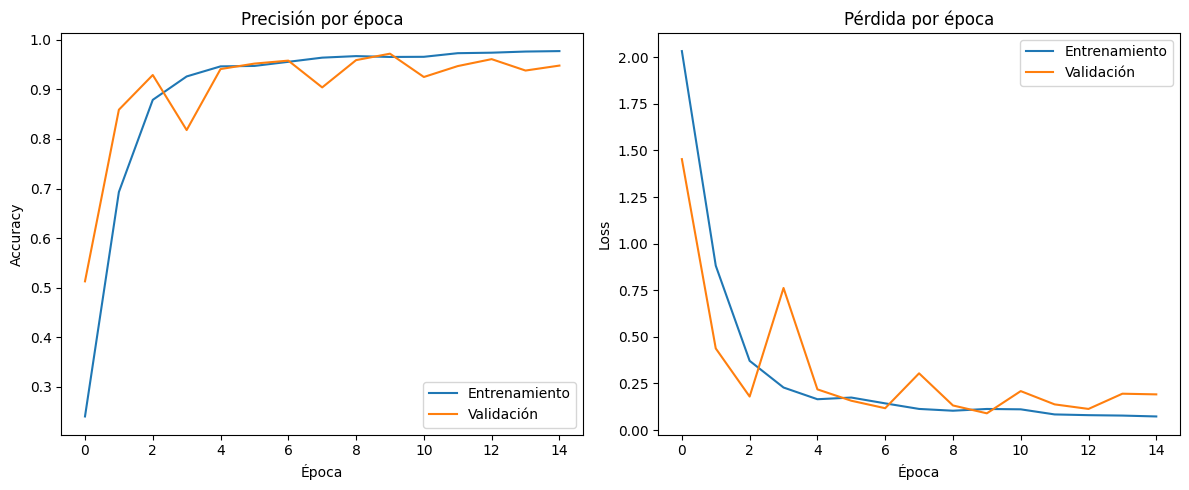

In [ ]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Entrenamiento")
plt.plot(history.history["val_accuracy"], label="Validación")
plt.title("Precisión por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


# 12. Visualización de predicciones

/tmp/ipython-input-17-1582368197.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(all_labels[index])   # <-- CORRECCIÓN AQUÍ


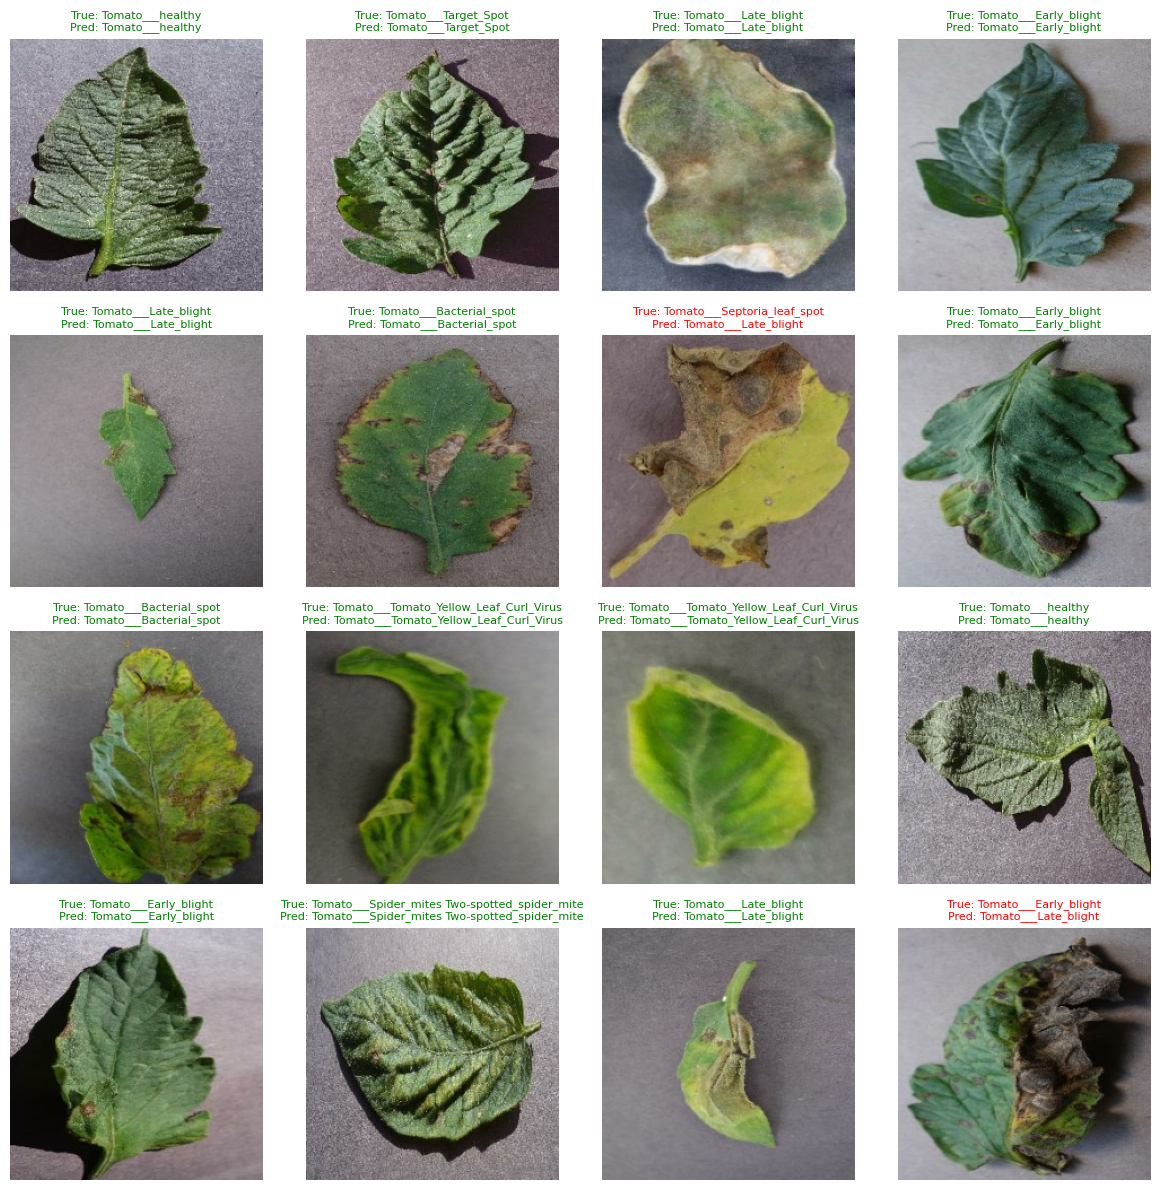

In [ ]:
model.load_weights("vgg16_best_model.keras")

# Extraemos todas las imágenes y etiquetas de validación
all_images = []
all_labels = []

for batch_images, batch_labels in val_dataset.unbatch().batch(1):
    all_images.append(batch_images[0].numpy())
    all_labels.append(batch_labels.numpy())

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Mezclar aleatoriamente y seleccionar 16 ejemplos
idx = np.random.choice(len(all_images), size=16, replace=False)

plt.figure(figsize=(12, 12))
for i, index in enumerate(idx):
    img = all_images[index]
    label = int(all_labels[index])   # <-- CORRECCIÓN AQUÍ

    pred_probs = model.predict(img[np.newaxis, ...], verbose=0)
    pred_idx = np.argmax(pred_probs)
    pred_class = class_names[pred_idx]
    true_class = class_names[label]

    color = "green" if pred_idx == label else "red"

    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f"True: {true_class}\nPred: {pred_class}", color=color, fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.show()

# 13. Matriz de confusión y reporte de clasificación

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

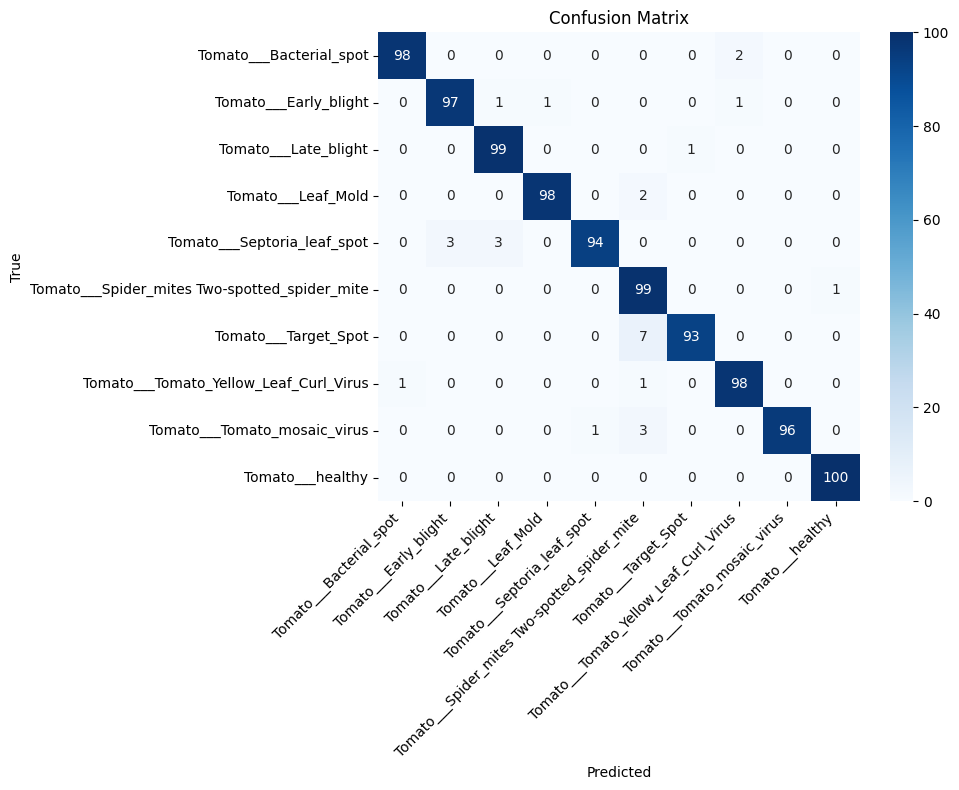

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.99      0.98      0.98       100
                        Tomato___Early_blight       0.97      0.97      0.97       100
                         Tomato___Late_blight       0.96      0.99      0.98       100
                           Tomato___Leaf_Mold       0.99      0.98      0.98       100
                  Tomato___Septoria_leaf_spot       0.99      0.94      0.96       100
Tomato___Spider_mites Two-spotted_spider_mite       0.88      0.99      0.93       100
                         Tomato___Target_Spot       0.99      0.93      0.96       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.97      0.98      0.98       100
                 Tomato___Tomato_mosaic_virus       1.00      0.96      0.98       100
                             Tomato___healthy       0.99      1.00      1.00       100

                                     accu

In [ ]:
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))
